# 1D Conv NN for IMDB

In [ ]:
# IMDB Data preprocessing
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, \
                            GlobalMaxPooling1D
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_features, 128, input_length=max_len))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

In [ ]:
model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 6s 22ms/step - loss: 0.6927 - acc: 0.5169 - val_loss: 0.6914 - val_acc: 0.5300
Epoch 2/10
157/157 [==============================] - 3s 19ms/step - loss: 0.6864 - acc: 0.6323 - val_loss: 0.6889 - val_acc: 0.4976
Epoch 3/10
157/157 [==============================] - 3s 19ms/step - loss: 0.6760 - acc: 0.7135 - val_loss: 0.6730 - val_acc: 0.6924
Epoch 4/10
157/157 [==============================] - 3s 19ms/step - loss: 0.6434 - acc: 0.7804 - val_loss: 0.6145 - val_acc: 0.7846
Epoch 5/10
157/157 [==============================] - 3s 20ms/step - loss: 0.5486 - acc: 0.8176 - val_loss: 0.4914 - val_acc: 0.8210
Epoch 6/10
157/157 [==============================] - 3s 19ms/step - loss: 0.4209 - acc: 0.8479 - val_loss: 0.3929 - val_acc: 0.8434
Epoch 7/10
157/157 [==============================] - 3s 19ms/step - loss: 0.3362 - acc: 0.8717 - val_loss: 0.3474 - val_acc: 0.8540
Epoch 8/10
157/157 [==============================] - 3s 20ms/step - 

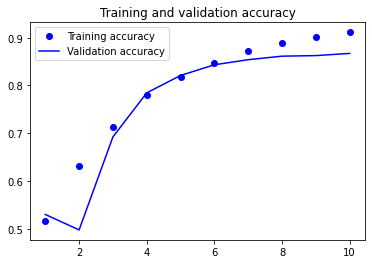

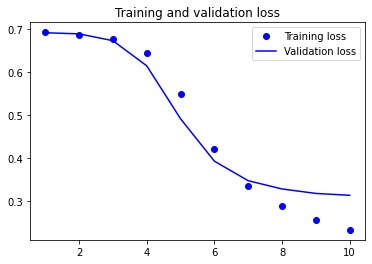

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Combining convolutional and recurrent NNs for processing long sequences

## Data Preprocessing

In [3]:
import os

data_dir = '/content/drive/MyDrive/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [5]:
lookback = 720
step = 6
delay = 144

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data - delay - 1)
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback,
                      delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      batch_size=batch_size,
                      step=step)

val_gen = generator(float_data,
                    lookback,
                    delay,
                    min_index=200001,
                    max_index=300000,
                    batch_size=batch_size,
                    step=step)

test_gen = generator(float_data,
                     lookback,
                     delay,
                     min_index=300001,
                     max_index=None,
                     batch_size=batch_size,
                     step=step)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## Simple 1D Conv NN

In [6]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, \
                            GlobalMaxPooling1D

model = Sequential()
model.add(Conv1D(32, 5, activation='relu', 
                 input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

model.compile(optimizer='rmsprop',
              loss='mae')

In [7]:
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 42s 24ms/step - loss: 0.4116 - val_loss: 0.4331
Epoch 2/20
500/500 [==============================] - 12s 23ms/step - loss: 0.3600 - val_loss: 0.4560
Epoch 3/20
500/500 [==============================] - 12s 23ms/step - loss: 0.3372 - val_loss: 0.4190
Epoch 4/20
500/500 [==============================] - 12s 24ms/step - loss: 0.3207 - val_loss: 0.4455
Epoch 5/20
500/500 [==============================] - 12s 23ms/step - loss: 0.3104 - val_loss: 0.4762
Epoch 6/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2987 - val_loss: 0.4457
Epoch 7/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2905 - val_loss: 0.4383
Epoch 8/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2842 - val_loss: 0.4285
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2794 - val_loss: 0.4397
Epoch 10/20
500/500 [==============================] - 12s 23ms/step - loss: 0.272

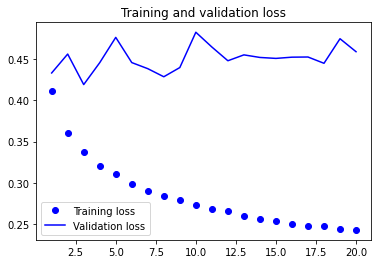

In [8]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## GRU & Conv1D together for long sequences

In [8]:
lookback = 720
step = 3
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback,
                      delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      batch_size=batch_size,
                      step=step)

val_gen = generator(float_data,
                    lookback,
                    delay,
                    min_index=200001,
                    max_index=300000,
                    batch_size=batch_size,
                    step=step)

test_gen = generator(float_data,
                     lookback,
                     delay,
                     min_index=300001,
                     max_index=None,
                     batch_size=batch_size,
                     step=step)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [9]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GRU, Dense

model = Sequential()
model.add(Conv1D(32, 5, activation='relu', 
                 input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))

model.compile(optimizer='rmsprop',
              loss='mae')

In [10]:
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 103s 199ms/step - loss: 0.3338 - val_loss: 0.2809
Epoch 2/20
500/500 [==============================] - 100s 200ms/step - loss: 0.2984 - val_loss: 0.2809
Epoch 3/20
500/500 [==============================] - 104s 207ms/step - loss: 0.2834 - val_loss: 0.2755
Epoch 4/20
500/500 [==============================] - 98s 195ms/step - loss: 0.2738 - val_loss: 0.2979
Epoch 5/20
500/500 [==============================] - 101s 201ms/step - loss: 0.2672 - val_loss: 0.2750
Epoch 6/20
500/500 [==============================] - 101s 202ms/step - loss: 0.2594 - val_loss: 0.2953
Epoch 7/20
500/500 [==============================] - 102s 205ms/step - loss: 0.2555 - val_loss: 0.2974
Epoch 8/20
500/500 [==============================] - 102s 204ms/step - loss: 0.2488 - val_loss: 0.2887
Epoch 9/20
500/500 [==============================] - 102s 203ms/step - loss: 0.2444 - val_loss: 0.2843
Epoch 10/20
500/500 [==============================] - 101s 201ms

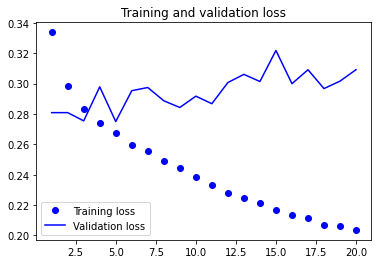

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()